## Import the modules

In [1]:
import pandas as pd # pandas is used to load and manipulate data and for One-Hot Encoding
import numpy as np # data manipulation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split # spit the data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.svm import SVC # this will make a support vector machine for classification
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import accuracy_score # to calculate accuracy
from sklearn.decomposition import PCA # to perform PCA to plot the data

/home/sannhtet/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


## Import the data

In [2]:
df = pd.read_csv('default of credit card clients.csv', header=1) # first row of the file is nonsense data

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Note the last column name "default payment next month" is so long. Let's change it to "default"...

In [3]:
df.rename({'default payment next month' : 'DEFAULT'}, axis='columns', inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Also, the values in ID column were randomly assigned, making it informative, so we can drop it...

In [4]:
df.drop('ID', axis=1, inplace=True) # set axis=0 to remove rows, and axis=1 to columns
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Missing Data Part 1: Identifying Missing Data

First, let's see what sort of data in each column.

In [5]:
df.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

Let's start by making sure SEX only contains the numbers 1 and 2.

In [6]:
df['SEX'].unique()

array([2, 1], dtype=int64)

Now let's look at Education and make sure it only contains 1, 2, 3 and 4.

In [7]:
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

Now let's look at MARRIAGE and make sure it only contains 1,2 and 3.

In [8]:
df['MARRIAGE'].unique()

array([1, 2, 3, 0], dtype=int64)

## Missing Data Part 2: Dealing With Missing Data

In [9]:
len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)])

68

In [10]:
len(df)

30000

So 18 of the 30000 rows or less than 1% contain missing values. Since that still leaves me with more data than I need for a Support Vector Machine, I'll remove the rows with missing values.

In [11]:
df_no_missing = df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]

In [12]:
len(df_no_missing)

29932

We can check to make sure all the missing data are gone.

In [13]:
df_no_missing['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6], dtype=int64)

In [14]:
df_no_missing['MARRIAGE'].unique()

array([1, 2, 3], dtype=int64)

## Downsample the data

**Support Vector Machine** are great with small datasets, but not awesome with large ones, and this dataset, while not huge, is big enough to take a long time to optimize with **Cross Validation**. So we'll downsample both categories, customers who did and did not default, to 1,000 each.

First, let's remind ourselves how many customers are in the dataset...

In [15]:
len(df_no_missing)

29932

**29932** samples is a relatively large number for a Support Vector Machine, so let's downsample.

In [16]:
df_no_default = df_no_missing[df_no_missing['DEFAULT'] == 0]
df_default = df_no_missing[df_no_missing['DEFAULT'] == 1]

Now downsample the dataset that did not default...

In [17]:
df_no_default_downsampled = resample(df_no_default,
                                     replace=False,
                                     n_samples=1000,
                                     random_state=42)
len(df_no_default_downsampled)

1000

Now downsample the dataset that defaulted...

In [18]:
df_default_downsampled = resample(df_default,
                                  replace=False,
                                  n_samples=1000,
                                  random_state=42)
len(df_default_downsampled)

1000

Now let's merge the two downsampled datasets into a single dataframe and print out the total number of samples to make sure everything is hunky dory.

In [19]:
df_downsample = pd.concat([df_no_default_downsampled, df_default_downsampled])
len(df_downsample)

2000

## Format Data Part 1: Split the Data into Dependent and Independent Variables

In [20]:
X = df_downsample.iloc[:,:-1].copy()
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,130000,2,3,1,28,0,0,0,0,-2,...,50000,0,0,0,2500,1000,0,0,0,0
4678,170000,1,3,1,29,0,0,0,0,0,...,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
16004,180000,2,2,1,29,0,0,0,0,0,...,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
22974,210000,2,2,2,32,-2,-2,-2,-2,-2,...,410,0,0,0,979,412,0,0,0,0
17535,190000,2,3,1,45,0,0,0,0,0,...,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [21]:
y = df_downsample['DEFAULT'].copy()
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: DEFAULT, dtype: int64

## Format the Data Part 2: One-Hot Encoding

**SEX**, **EDUCATION**, **MARRIAGE** and **PAY** are supported to be categorical and need to be modified.

In [22]:
X_encoded = pd.get_dummies(X, columns=['SEX',
                                       'EDUCATION',
                                       'MARRIAGE',
                                       'PAY_0',
                                       'PAY_2',
                                       'PAY_3',
                                       'PAY_4',
                                       'PAY_5',
                                       'PAY_6'])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000,28,100143,50456,50000,0,0,0,2500,1000,...,0,1,0,0,0,0,0,0,0,0
4678,170000,29,165027,168990,172307,35234,32869,33862,7200,7500,...,0,0,0,1,0,0,0,0,0,0
16004,180000,29,25781,26000,26310,26662,26166,26176,1800,1800,...,0,0,0,1,0,0,0,0,0,0
22974,210000,32,355,975,410,0,0,0,979,412,...,0,1,0,0,0,0,0,0,0,0
17535,190000,45,76433,78472,80548,81778,83082,84811,3300,3331,...,0,0,0,1,0,0,0,0,0,0


## Format the Data Part 3: Centering and Scaling

**NOTE**: We split the data into trainig and testing datasets and then scale them separately to avoid **Data Leakage**. **Data Leakage** occurs when information about the training dataset corrupts or influences the testing dataset.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

## Build A Preliminary Support Vector Machine

In [24]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

/home/sannhtet/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


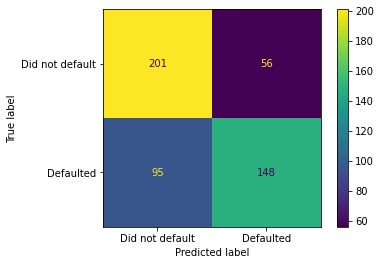

In [25]:
plot_confusion_matrix(clf_svm,
                      X_test_scaled,
                      y_test,
                      values_format='d',
                      display_labels=["Did not default", "Defaulted"])

In [26]:
y_pred = clf_svm.predict(X_test)
accuracy_score(y_test, y_pred)

/home/sannhtet/.local/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.486

## Optimize Parameters with Cross Validation and GridSearchCV()

Since we have two parameters to optimize, we will use **GridSearchCV()**. We specify a bunch of potential values for gamma and C, and **GridSearchCV()** tests all possible combinations of the parameters for us.

In [31]:
param_grid = [
    {'C':[0.5, 1, 10, 100], # NOTE: Values for C must be > 0
     'gamma':['scale', 1, 0.1, 0.01, 0.001, 0.0001],
     'kernel':['rbf']},
]

## NOTE: We are including C=1 and gamma='scale'
## as possible choices since they are the default values.

optimal_params = GridSearchCV(
                            SVC(),
                            param_grid,
                            cv=5,
                            scoring='accuracy',
                            verbose=0 # NOTE: If you want to see what Grid Search is doing, set verose=2
                        )
optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


## Building, Evaluating, Drawing and Interpreting the Final Support Vector Machine

Now that I have the ideal values for C and gamma, we can build the final **Support Vector Machine**

In [36]:
clf_svm = SVC(random_state=42, C=100, gamma=0.001)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001, random_state=42)

/home/sannhtet/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


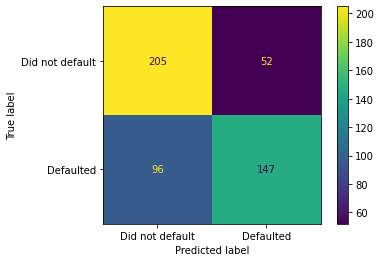

In [37]:
plot_confusion_matrix(clf_svm,
                      X_test_scaled,
                      y_test,
                      values_format='d',
                      display_labels=["Did not default", "Defaulted"])

The last thing I am going to do is draw a support vector machine decision boundary and discuss how to interpret it.

The first thing I need to do is count the number of columns in **X**:

In [38]:
len(df_downsample.columns)

24

I can't plot mutiple dimensions. So I have to use **Principal Component Analysis** to plot the data.

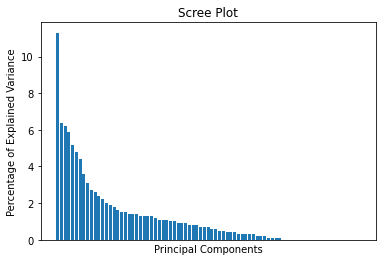

In [39]:
pca = PCA() # NOTE: By default, PCA() centers the data, but does not scale it.
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',          # changes apply to the x_axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

The scree plot shows that the first principal component, PC1, accounts for a relatively large amount of variation in the raw data, and this means that it will be a good candidate for the x-axis in the 2-dimensiondal graph. However, PC2 is not much different from PC3 and PC4, which doesn't bode well for dimension reduction. Since I don't have a choice, let's go with it, but don't be surprised if the final graph looks funky.

Now I will draw PCA graph. First, let's optimize a SVM fit to PC1 and PC2.

In [40]:
train_pc1_coords = X_train_pca[:,0]
train_pc2_coords = X_train_pca[:,1]

## Note:
## pc1 contains the x_axis coordinates of the data after PCA
## pc2 contains the y_axis coordinates of the data after PCA

## Now center and scale the PCs...
pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

## Now I optimize the SVM fit to the x and y-axis coordinates
## of the data after PCA dimension reduction...
param_grid = [
    {'C':[1, 10, 100, 1000], # NOTE: Values for C must be > 0
     'gamma':['scale', 1, 0.1, 0.01, 0.001, 0.0001],
     'kernel':['rbf']}
]

optimal_params = GridSearchCV(
                            SVC(),
                            param_grid,
                            cv=5,
                            scoring='accuracy',
                            verbose=0 # NOTE: If you want to see what Grid Search is doing, set verose=2
                        )
optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


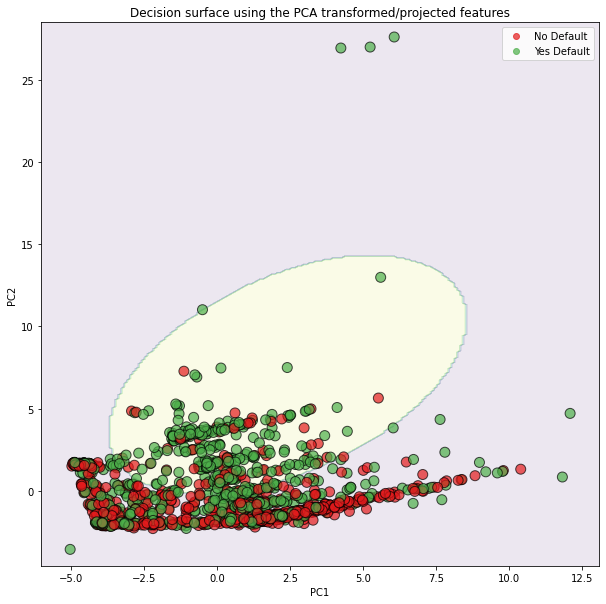

In [41]:
clf_svm = SVC(random_state=42, C=1000, gamma=0.001)
clf_svm.fit(pca_train_scaled, y_train)

## Transform the test dataset with the PCA...
X_test_pca = pca.transform(X_train_scaled)
test_pc1_coords = X_test_pca[:,0]
test_pc2_coords = X_test_pca[:,1]

## Now create a matrix of points that can use to show
## the decision regions.
## The matrix will be a little bit larger than the
## transformed PCA points so that we can plot all of
## the PCA points on it without them being on the edge
x_min = test_pc1_coords.min() -1
x_max = test_pc1_coords.max() + 1

y_min = test_pc2_coords.min() -1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

## now I will classify every point in that
## matrix with the SVM. Points on one side of the
## classification boundary will get 0, and points on the other
## side will get 1.
Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))
## Right now, Z is just a long array of lots of 0s and 1s, which
## reflect how each point in the mesh was classified.
## I use reshape() so that each classification (0 or 1) corresponds
## to a specific point in the matrix.
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))
## Now I will use contourf() to draw a filled contour plot
## using the matrix values and classifications.
## The contours will be filled according to the
## predicted classifications (0s and 1s) in Z
ax.contourf(xx, yy, Z, alpha=0.1)

## Now create custom colors for the actual data points
cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])
## now draw the actual data points - these will
## be colored by their known (not predicted) classifications
## NOTE: setting alpha=0.7 lets me see if I am covering up a point
scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_train,
                     cmap=cmap,
                     s=100,
                     edgecolors='k', ## 'k' = black
                     alpha=0.7)

## Now create a legend
legend = ax.legend(scatter.legend_elements()[0],
                   scatter.legend_elements()[1],
                   loc="upper right")
legend.get_texts()[0].set_text("No Default")
legend.get_texts()[1].set_text("Yes Default")

## Now add axis labels and titles
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decision surface using the PCA transformed/projected features')
plt.show()